# Convolution Neural Networks
Link to the dataset : https://drive.google.com/file/d/14HjM98X9T2LIw7L5Io6kq0uRc9GFN93z/view?usp=sharing

# Task: Word Recognition

The objective is to train a deep CNN model that can help in recognising a word, i.e. given a word-image(image with a word present in it) as input, the model yields a representation that can help in recognising the word from a set of possible words (termed as  'lexicon' of words). 

---

## Representations of the word

There are two representations for a word:

1. **Alpha representation**: This is based on the claim that a word can be represented in terms of occurences of characters in various segments of image.

The word is split into equal parts at various levels.

At level *i*:  
* A word is split into *i* (nearly) equal segments.  
* For every segment, we compute a binary vector in which each segment correspond to alphabets/characters (Shown in fig.).

![Alpha Vector](https://drive.google.com/uc?export=view&id=17rUvYXvWUc2IP8aD-O3kualSjr2dcn2b)

*  Individual vectors of each segment are concatenated after one another, i.e. the level vector is obtained by concatenating individual vectors of first segment followed by second, third and so on.

The final vector is obtained by concatenating vectors of all levels $\{L_i.L_{i+1}.L_{i+2}\cdots\}$.


*For this assignment, you are supposed to use levels 2-5. 
This makes the length of final Alpha vector to be (2+3+4+5) * 26 = 364*



2. **Omega representation**: This is based on the claim that a word can be represented in terms of count of 11 primitve shapes present in various segments of image. The 11 shapes are: *ascender, descender, left small semi-circle, right small semi-circle, left large semi-circle, right large semi-circle, circle, vertical line, diagonal line, diagonal line at a slope of 135 degrees, and horizontal line*. These have been shown in figure.

![Primary Shapes](https://drive.google.com/uc?export=view&id=1573VBQwD03ae_UBjDaYk4fq84bGmDzr2)

The word is split into equal parts at various levels.

At level *i*:  
* A word is split into *i* (nearly) equal segments.  
* For every segment, we compute a vector in which each segment correspond to count of a shape.

![Omega for anagram](https://drive.google.com/uc?export=view&id=1nk1pj0yp5wunCxYeUp5ppH8hdsHF41rv)


*  Individual vectors of each segment are concatenated after one another, i.e. the level vector is obtained by concatenating individual vectors of first segment followed by second, third and so on.

The final vector is obtained by concatenating vectors of all levels $\{L_i.L_{i+1}.L_{i+2}\cdots\}$.

*For this assignment, you are supposed to use levels 1-5. 
This makes the length of final Omega vector to be (1+2+3+4+5) * 11 = 165*

---

**Note**: For both representations, while splitting, in case of unequal lengths of segments, segments at the end should be of more length e.g. Level 3 split of "omega" = {o,me,ga} and "play" = {p,l,ay}. Also, for a smaller words like "ok" level 3 split = {$\epsilon$,o,k} where $\epsilon$ = empty string. 

---

Your final goal of this assignment is to detemine which representation will be more helpful for word recognition. 



In [1]:
# Import the necessary libraries

import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import matplotlib.pyplot as plt
import os
import shutil
import random

# If using Google Colab, use the following package to display the image
# If running on your local system, cv2.imshow shall work fine
# If running on your local system please comment the line below
from google.colab.patches import cv2_imshow
from google.colab.patches import cv2_imshow
from google.colab import drive
drive.mount('/content/gdrive')
# I have unzipped the dataset folder myself and then uploaded it to my drive with no change in the names of any folder or files ,
# so i am not unzipping using colab

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


ModuleNotFoundError: No module named 'seaborn'

In [ ]:
IMG_HEIGHT = 50
IMG_WIDTH = 250

# Dataset

The dataset used here is a synthetic word recognition dataset. It consists of images of lowercase English words, generated with handwritten-fonts. All images are single channel (grayscale) and have size 250 * 50. <br>

The dataset has the following directory structure:

<pre>
<b>WR-Dataset</b>
|__ <b>train</b>: [foo_1.png, bar_2.png, sample_3.png ....]
|__ <b>validation</b>: [foo_221.png, bar_322.png, sample_353.png ....]
|__ <b>test</b>: [bar_521.png, foo_272.png, example_433.png ....]
|__ <b>Alphabet.csv</b>
    
</pre>

Extract the paths of these directories onto different variables to facilitate accessing the dataset and thereby training the model.

In [ ]:
#Add the paths for train, validation and test directories

train_dir_path="/content/gdrive/MyDrive/WR-Dataset_partb/Train"
validation_dir_path="/content/gdrive/MyDrive/WR-Dataset_partb/Validation"
test_dir_path="/content/gdrive/MyDrive/WR-Dataset_partb/Test"

# Visualizing sample images

Prepare an image to label map and visualize 5 randomly chosen images from training, validation and test sets (along with their labels). Also, Mention the number of word classes present in each of the three sets.

----

**(1+1+1) points**

---

                                                  Image     Label
0     [[[255, 255, 255], [255, 255, 255], [255, 255,...      days
1     [[[255, 255, 255], [255, 255, 255], [255, 255,...  business
2     [[[255, 255, 255], [255, 255, 255], [255, 255,...      with
3     [[[255, 255, 255], [255, 255, 255], [255, 255,...   support
4     [[[255, 255, 255], [255, 255, 255], [255, 255,...     being
...                                                 ...       ...
2047  [[[255, 255, 255], [255, 255, 255], [255, 255,...      life
2048  [[[255, 255, 255], [255, 255, 255], [255, 255,...      real
2049  [[[255, 255, 255], [255, 255, 255], [255, 255,...     south
2050  [[[255, 255, 255], [255, 255, 255], [255, 255,...        uk
2051  [[[255, 255, 255], [255, 255, 255], [255, 255,...     phone

[2052 rows x 2 columns]
                                                 Image      Label
0    [[[255, 255, 255], [255, 255, 255], [255, 255,...         he
1    [[[255, 255, 255], [255, 255, 255], [255, 255,

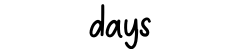

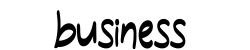

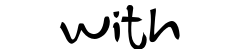

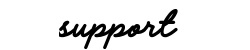

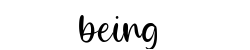



Display images from the validation set


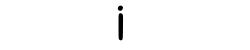

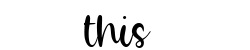

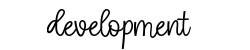

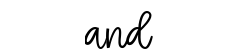

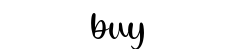



Display images from the test set


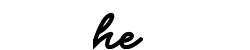

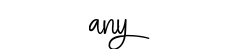

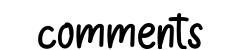

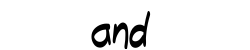

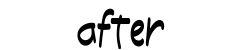

In [ ]:
def get_dataframe(folder_name):
    # Insert code to give you list of all the image files in folder
    images=[]
    labels=[]


    # Insert code to get list of labels from list of images 
    for filename in os.listdir(folder_name):
        img = cv2.imread(os.path.join(folder_name,filename))
        if img is not None:
          images.append(img)
          # cv2_imshow(img)
          # (Hint: every image file name has its label name as prefix)
        # images.append(os.path.join(folder_name,filename))

        currlabel=""
        for i in filename:
          if i=='_':
            break
          else:
            currlabel+=i
        labels.append(currlabel)

    # Make a dataframe with two columns - Image(file name) and Label (class label)
    data={'Image': images, 'Label': labels}
    dataframe=pd.DataFrame(data)

    #display and return the dataframe
    return dataframe

# Insert code to build a dataframe with Images and their corresponding labels for 3 folders (similar to Lab 3(a))
train_dataframe=get_dataframe("/content/gdrive/MyDrive/WR-Dataset_partb/Train")
test_dataframe=get_dataframe("/content/gdrive/MyDrive/WR-Dataset_partb/Test")
validation_dataframe=get_dataframe("/content/gdrive/MyDrive/WR-Dataset_partb/Validation")


# display the dataframes
print(train_dataframe)
print(test_dataframe)
print(validation_dataframe)



# Visualise images from the train set
print("Display Images from the train set")
for i in range(5):
  # img = cv2.imread(train_dataframe['Image'][i])
  cv2_imshow(train_dataframe['Image'][i])

print("\n")


# Visualise images from the validation set
print("Display images from the validation set")
for i in range(5):
  # img = cv2.imread(validation_dataframe['Image'][i])
  cv2_imshow(validation_dataframe['Image'][i])

print("\n")



# Visualise images from the test set
print("Display images from the test set")
for i in range(5):
  # img = cv2.imread(test_dataframe['Image'][i])
  cv2_imshow(test_dataframe['Image'][i])





Now, you will have to write modules that can give you vector representations for the input words.

---

**(3 + 3 points)**

---

In [ ]:
weight_list=[]
from csv import reader
with open('/content/gdrive/MyDrive/WR-Dataset_partb/Alphabet.csv', 'r') as read_obj:
    csv_reader = reader(read_obj)
    for row in csv_reader:
      weight_list.append(row)
for i in range(len(weight_list)):
  weight_list[i].remove(weight_list[i][0])

for i in range(len(weight_list)):
  for j in range(len(weight_list[i])):
    weight_list[i][j]=ord(weight_list[i][j])-ord('0')

  
def get_Omega_vector(word):
  #Insert the code for a function that returns Omega representation of the input word
  omega_vector=np.array([])
  for i in range(1,6):
    seg_len=len(word)//i
    start=0
    for j in range(i):
      curr_vec=[]
      for k in range(11):
        curr_vec.append(0)
      curr_vec=np.array(curr_vec)
      if j!=i-1:
        for k in range(seg_len):
          curr_vec=np.add(curr_vec, np.array(weight_list[ord(word[start+k].lower())-97]))
        start+=seg_len
      else:
        for k in range(start, len(word)):
          curr_vec=np.add(curr_vec, np.array(weight_list[ord(word[k])-97]))
      omega_vector=np.concatenate((omega_vector,np.array(curr_vec)))
  return omega_vector

  #Hint: For computing count of segments, you can add count of shapes for individual characters (already provided in Alphabet.csv file)

In [ ]:
def get_Alpha_vector(word):
  #Insert the code for a function that returns Alpha representation of the input word 
  alpha_vector=np.array([])
  for i in range(2,6):
    seg_len=len(word)//i
    start=0
    for j in range(i):
      curr_vec=[]
      for k in range(26):
        curr_vec.append(0)
      if j!=i-1:
        for k in range(seg_len):
          curr_vec[ord(word[start+k])-97]+=1
        start+=seg_len
      else:
        for k in range(start, len(word)):
          curr_vec[ord(word[k])-97]+=1
      alpha_vector=np.concatenate((alpha_vector,np.array(curr_vec)))
  return alpha_vector


To test the above modules, try printing Omega and Alpha vectors for your first name.

In [ ]:
name ="shivam"

print("Omega vector:\n",get_Omega_vector(name))
print("Length of Omega vector = ", len(get_Omega_vector(name)))
print("\n")
print("Alphavector:\n",get_Alpha_vector(name))
print("Length of Alpha vector = ", len(get_Alpha_vector(name)))

Omega vector:
 [1. 0. 2. 0. 1. 0. 1. 6. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 2. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 1. 4. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 4. 0. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 4. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 4. 0. 0. 0.]
Length of Omega vector =  165


Alphavector:
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

# Building Alpha model architecture 

Following is the architecture of the model that will learn Alpha representation:

Input shape: 250 * 50 ( RGB )


* 2 Convolution layers with 64  filters
* A Max Pool layer with pool size 2 * 2   
* 2 Convolution layers with 128  filters
* A Max Pool layer with pool size 2 * 2    
* 6 Convolution layers with 256  filters
* 3 Convolution layers with 512  filters
* GLobal Average Pooling layer
* Dense  layer with 4096 units
* Dropout layer with rate 0.5
* Dense  layer with 4096 units
* Dropout layer with rate 0.5
* Dense  layer with 364 units (Output)

For all convolution layers, keep kernel size as 3 * 3, use ReLu activation 

For all max pool layers, keep stride as 2

For all dense layers, except the final layer use ReLu activation.

For final layer, use sigmoid activation.

**Loss function**: Binary cross-entropy

**Similarity Metric**: Cosine Similarity

You need to make a function that will take a learning rate as parameter as return the compiled Alpha model.

---

**(3 points)**

---

In [ ]:
#Insert the code for function that returns a model which will predict Alpharepresentation

def Alpha_model(learning_rate=1e-4):
   # Instantiate Sequential model
   model = tf.keras.models.Sequential()
   
   # Add Layers
   model.add(tf.keras.layers.Conv2D(64,(3,3),activation='relu',input_shape=(IMG_HEIGHT,IMG_WIDTH, 3),padding='same'))
   model.add(tf.keras.layers.Conv2D(64,(3,3),activation='relu',input_shape=(IMG_HEIGHT,IMG_WIDTH, 3),padding='same'))
   model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2),strides=2))
   model.add(tf.keras.layers.Conv2D(128,(3,3),activation='relu',input_shape=(IMG_HEIGHT,IMG_WIDTH, 3),padding='same'))
   model.add(tf.keras.layers.Conv2D(128,(3,3),activation='relu',input_shape=(IMG_HEIGHT,IMG_WIDTH, 3),padding='same'))
   model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2),strides=2))
   model.add(tf.keras.layers.Conv2D(256,(3,3),activation='relu',input_shape=(IMG_HEIGHT,IMG_WIDTH, 3),padding='same'))
   model.add(tf.keras.layers.Conv2D(256,(3,3),activation='relu',input_shape=(IMG_HEIGHT,IMG_WIDTH, 3),padding='same'))    
   model.add(tf.keras.layers.Conv2D(256,(3,3),activation='relu',input_shape=(IMG_HEIGHT,IMG_WIDTH, 3),padding='same'))
   model.add(tf.keras.layers.Conv2D(256,(3,3),activation='relu',input_shape=(IMG_HEIGHT,IMG_WIDTH, 3),padding='same'))
   model.add(tf.keras.layers.Conv2D(256,(3,3),activation='relu',input_shape=(IMG_HEIGHT,IMG_WIDTH, 3),padding='same'))
   model.add(tf.keras.layers.Conv2D(256,(3,3),activation='relu',input_shape=(IMG_HEIGHT,IMG_WIDTH, 3),padding='same'))
   model.add(tf.keras.layers.Conv2D(512,(3,3),activation='relu',input_shape=(IMG_HEIGHT,IMG_WIDTH, 3),padding='same'))
   model.add(tf.keras.layers.Conv2D(512,(3,3),activation='relu',input_shape=(IMG_HEIGHT,IMG_WIDTH, 3),padding='same'))
   model.add(tf.keras.layers.Conv2D(512,(3,3),activation='relu',input_shape=(IMG_HEIGHT,IMG_WIDTH, 3),padding='same'))
   model.add(tf.keras.layers.GlobalAveragePooling2D())
   model.add(tf.keras.layers.Dense(4096, activation='relu'))
   model.add(tf.keras.layers.Dropout(0.5))
   model.add(tf.keras.layers.Dense(4096, activation='relu'))
   model.add(tf.keras.layers.Dropout(0.5))
   model.add(tf.keras.layers.Dense(364,activation='sigmoid'))
   
   
   
   # Define optimizers(Adam Optimizers), loss function and similarity metrics
   opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
   bce = tf.keras.losses.BinaryCrossentropy()
   metrics=[tf.keras.metrics.CosineSimilarity()]
   
   # Compile the model
   model.compile(optimizer=opt, loss=bce, metrics=metrics)
   
   # return model
   return model

Following is the architecture of the Omega model, i.e. model that will learn to predict Omega representation:

Input shape: 250 * 50 ( RGB )


* 2 Convolution layers with 64  filters
* A Max Pool layer with pool size 2 * 2   
* 2 Convolution layers with 128  filters
* A Max Pool layer with pool size 2 * 2    
* 6 Convolution layers with 256  filters
* 3 Convolution layers with 512  filters
* GLobal Average Pooling layer
* Dense  layer with 4096 units
* Dropout layer with rate 0.5
* Dense  layer with 4096 units
* Dropout layer with rate 0.5
* Dense  layer with 165 units (Output)

For all convolution layers, keep kernel size as 3 * 3, use ReLu activation 

For all max pool layers, keep stride as 2

For all dense layers, use ReLu activation.

**Loss function**: Mean-squared error

**Similarity Metric**: Cosine Similarity

You need to make a function that will take a learning rate as parameter as return the compiled Omega model.

---

**(3 points)**

---

In [ ]:
def Omega_model(learning_rate=1e-4):
    model = tf.keras.models.Sequential()
    
    # Add Layers
    model.add(tf.keras.layers.Conv2D(64,(3,3),activation='relu',input_shape=(IMG_HEIGHT,IMG_WIDTH, 3),padding='same'))
    model.add(tf.keras.layers.Conv2D(64,(3,3),activation='relu',input_shape=(IMG_HEIGHT,IMG_WIDTH, 3),padding='same'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2),strides=2))
    model.add(tf.keras.layers.Conv2D(128,(3,3),activation='relu',input_shape=(IMG_HEIGHT,IMG_WIDTH, 3),padding='same'))
    model.add(tf.keras.layers.Conv2D(128,(3,3),activation='relu',input_shape=(IMG_HEIGHT,IMG_WIDTH, 3),padding='same'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2),strides=2))
    model.add(tf.keras.layers.Conv2D(256,(3,3),activation='relu',input_shape=(IMG_HEIGHT,IMG_WIDTH, 3),padding='same'))
    model.add(tf.keras.layers.Conv2D(256,(3,3),activation='relu',input_shape=(IMG_HEIGHT,IMG_WIDTH, 3),padding='same'))    
    model.add(tf.keras.layers.Conv2D(256,(3,3),activation='relu',input_shape=(IMG_HEIGHT,IMG_WIDTH, 3),padding='same'))
    model.add(tf.keras.layers.Conv2D(256,(3,3),activation='relu',input_shape=(IMG_HEIGHT,IMG_WIDTH, 3),padding='same'))
    model.add(tf.keras.layers.Conv2D(256,(3,3),activation='relu',input_shape=(IMG_HEIGHT,IMG_WIDTH, 3),padding='same'))
    model.add(tf.keras.layers.Conv2D(256,(3,3),activation='relu',input_shape=(IMG_HEIGHT,IMG_WIDTH, 3),padding='same'))
    model.add(tf.keras.layers.Conv2D(512,(3,3),activation='relu',input_shape=(IMG_HEIGHT,IMG_WIDTH, 3),padding='same'))
    model.add(tf.keras.layers.Conv2D(512,(3,3),activation='relu',input_shape=(IMG_HEIGHT,IMG_WIDTH, 3),padding='same'))
    model.add(tf.keras.layers.Conv2D(512,(3,3),activation='relu',input_shape=(IMG_HEIGHT,IMG_WIDTH, 3),padding='same'))
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Dense(4096, activation='relu',kernel_initializer='glorot_uniform'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(4096, activation='relu',kernel_initializer='glorot_uniform'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(165,activation='relu'))
    # Define optimizers(Adam Optimizers), loss function and similarity metrics
    opt = tf.keras.optimizers.Adam(learning_rate)
    mse=tf.keras.losses.MeanSquaredError()
    metrics=[tf.keras.metrics.CosineSimilarity()]
    # Compile the model
    model.compile(optimizer=opt, loss=mse, metrics=metrics)
    # return model
    return model

Why did we use BCE as loss function and sigmoid as activation for final layer in Alpha model, while MSE and ReLu for Omega model? 

----

**2 points**

---





## Seen and Unseen Words

Words whose images hase been seen by the model during training are termed as seen words, while those which are part of the test set but not seen during training are called unseen words.

----

**1 point**

---

In [ ]:
#Insert code to print seen word classes 
print("Seen words Classes")
seen_class=[]
for i in train_dataframe['Label']:
  seen_class.append(i)
seen_class=set(seen_class)
print(seen_class)
print("\n")

print("Unseen word classes")
#Insert code to print unseen word classes from test set

unseen_class=[]
for i in test_dataframe['Label']:
  if i not in seen_class:
    unseen_class.append(i)
unseen_class=set(unseen_class)
print(unseen_class)
print("\n")


Seen words Classes
{'you', 'code', 'free', 'such', 'page', 'and', 'both', 'open', 'group', 'each', 'here', 'all', 'name', 'had', 'price', 'service', 'program', 'area', 'may', 'like', 'make', 'international', 'email', 'type', 'community', 'when', 'review', 'subject', 'item', 'help', 'with', 'not', 'take', 'it', 'the', 'research', 'links', 'do', 'company', 'only', 'up', 'version', 'privacy', 'be', 'being', 'technology', 'was', 'use', 'us', 'have', 'home', 'office', 'am', 'about', 'today', 'but', 'click', 'within', 'order', 'related', 'how', 'of', 'center', 'will', 'our', 'x', 'store', 'also', 'music', 'who', 'message', 'w', 'product', 'games', 'address', 'now', 'women', 'day', 't', 'even', 'states', 'is', 'other', 're', 'using', 'off', 'know', 'reviews', 'hotels', 'add', 'january', 'link', 'work', 'section', 'terms', 'list', 'world', 'your', 'people', 'has', 'results', 'services', 'would', 'health', 'b', 'more', 's', 'case', 'information', 'her', 'are', 'phone', 'than', 'these', 'pm', 'u

In [ ]:
NUM_EPOCHS=30
BATCH_SIZE=8

# Tuning Hyperparameters for Omega Model
We will now tune the *learning rate* for the first model. 
For that, load the train and validation data (images and their labels, i.e. Omega vectors) 

----

**1 point**

---

In [ ]:
#Insert the code for loading train and validation set images and their corresponding labels 
x_train=list(pd.DataFrame(train_dataframe,columns=['Image'])['Image'])
word_label=list(pd.DataFrame(train_dataframe,columns=['Label'])['Label'])
# print(word_label)
y_train_Omega=[]
for i in word_label:
  y_train_Omega.append(get_Omega_vector(i))


# print(np.array(word_label).shape)
x_val=list(pd.DataFrame(validation_dataframe,columns=['Image'])['Image'])
word_label=list(pd.DataFrame(validation_dataframe,columns=['Label'])['Label'])
y_val_Omega=[]
for i in word_label:
  y_val_Omega.append(get_Omega_vector(i))


x_train=np.divide(x_train, 255)
x_val=np.divide(x_val, 255)


x_train=np.array(x_train).reshape(len(x_train), 50, 250, 3)
x_val=np.array(x_val).reshape(len(x_val), 50, 250, 3)



y_train_Omega_list=np.empty((0,165), int)
for i in y_train_Omega:
 y_train_Omega_list=np.append(y_train_Omega_list,np.array([i]),axis=0)
  
y_val_Omega_list=np.empty((0,165), int)
for i in y_val_Omega:
  y_val_Omega_list=np.append(y_val_Omega_list,np.array([i]),axis=0)




Now find the best LR for the Omega model.

----

**4 points**

---

In [ ]:
def determine_Omega_lr():
    learning_rates = [1e-3,1e-4,1e-5]
    avg_val_similarity = []
    

    for l_rate in learning_rates:
        
        # Insert your code here to build a model with the current learning rate
        model=Omega_model(learning_rate=l_rate)
        
#         X_train = X_train.reshape(X_train.shape[0], img_cols, img_rows, 1)
# X_test = X_test.reshape(X_test.shape[0], img_cols, img_rows, 1)
# and

# input_shape=(img_cols, img_rows, 1)

        # Insert your code here to train the model using the training set and validate using the validation set
        hist=model.fit(x=x_train, y=y_train_Omega_list, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(x_val, y_val_Omega_list))
        
        # Insert your code here to find the average validation accuracy for this model setting and append it to the maintained list
        avg_val_similarity.append(np.mean(hist.history['val_cosine_similarity']))

        

    # Insert your code here to figure out the learning rate which gives the highest average validation accuracy. Print the value and return it.
    high_val_acc=0
    best_lr=0
    for i in range(len(avg_val_similarity)):
      if high_val_acc < avg_val_similarity[i]:
        high_val_acc=avg_val_similarity[i]
        best_lr=learning_rates[i]
    print("Highest average validation accuracy = ", end="")
    print(high_val_acc*100, end="")
    print("%", "Corresponding learning rate = ", end="")
    print(best_lr)
    return best_lr
    


# determine_best_learning_rate() is being called here
best_Omega_lr = determine_Omega_lr()

Epoch 1/30
257/257 [==============================] - 35s 74ms/step - loss: 26.5062 - cosine_similarity: 0.6289 - val_loss: 0.3166 - val_cosine_similarity: 0.7309
Epoch 2/30
257/257 [==============================] - 17s 68ms/step - loss: 0.3279 - cosine_similarity: 0.7038 - val_loss: 0.3134 - val_cosine_similarity: 0.7328
Epoch 3/30
257/257 [==============================] - 18s 69ms/step - loss: 0.3175 - cosine_similarity: 0.7046 - val_loss: 0.3120 - val_cosine_similarity: 0.7320
Epoch 4/30
257/257 [==============================] - 18s 70ms/step - loss: 0.3316 - cosine_similarity: 0.7054 - val_loss: 0.3103 - val_cosine_similarity: 0.7334
Epoch 5/30
257/257 [==============================] - 18s 71ms/step - loss: 0.3258 - cosine_similarity: 0.7065 - val_loss: 0.3113 - val_cosine_similarity: 0.7348
Epoch 6/30
257/257 [==============================] - 18s 72ms/step - loss: 0.3241 - cosine_similarity: 0.7062 - val_loss: 0.3118 - val_cosine_similarity: 0.7333
Epoch 7/30
257/257 [=======

# Tuning Hyperparameters for Alpha Model
We will now tune the *learning rate* for the second model. 

For that, load the train and validation data (images and their labels, i.e. Alpha vectors) 

---

**1 Point**

---

In [ ]:
#Insert the code for loading train and validation set images and their corresponding labels (1 point)
#Insert the code for loading train and validation set images and their corresponding labels (1 point)
x_train=list(pd.DataFrame(train_dataframe,columns=['Image'])['Image'])
word_label=list(pd.DataFrame(train_dataframe,columns=['Label'])['Label'])
y_train_alpha=[]
for i in word_label:
  y_train_alpha.append(get_Alpha_vector(i))



x_val=list(pd.DataFrame(validation_dataframe,columns=['Image'])['Image'])
word_label=list(pd.DataFrame(validation_dataframe,columns=['Label'])['Label'])
y_val_alpha=[]
for i in word_label:
  y_val_alpha.append(get_Alpha_vector(i))


x_train=np.divide(x_train, 255)
x_val=np.divide(x_val, 255)


x_train=np.array(x_train).reshape(len(x_train), 50, 250, 3)
x_val=np.array(x_val).reshape(len(x_val), 50, 250, 3)

y_train_alpha_list=np.empty((0,364), int)
for i in y_train_alpha:
  y_train_alpha_list=np.append(y_train_alpha_list,np.array([i]),axis=0)
  
y_val_alpha_list=np.empty((0,364), int)
for i in y_val_alpha:
  y_val_alpha_list=np.append(y_val_alpha_list,np.array([i]),axis=0)



Now find the best LR for the Omega model.

----

**4 points**

---

In [ ]:
def determine_Alpha_lr():
    learning_rates = [1e-3,1e-4,1e-5]
    avg_val_similarity = []
    

    for l_rate in learning_rates:
        
        # Insert your code here to build a model with the current learning rate
        model=Alpha_model(learning_rate=l_rate)
        
        # Insert your code here to train the model using the training set and validate using the validation set
        hist=model.fit(x_train, y_train_alpha_list, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(x_val, y_val_alpha_list))
        
        # Insert your code here to find the average validation similarity for this model setting and append it to the maintained list
        avg_val_similarity.append(np.mean(hist.history['val_cosine_similarity']))

    # Insert your code here to figure out the learning rate which gives the highest average validation similarity. Print the value and return it.
    high_val_acc=0
    best_lr=0
    for i in range(len(avg_val_similarity)):
      if high_val_acc < avg_val_similarity[i]:
        high_val_acc=avg_val_similarity[i]
        best_lr=learning_rates[i]
    print("Highest average validation accuracy = ", end="")
    print(high_val_acc*100, end="")
    print("%", "Corresponding learning rate = ", end="")
    print(best_lr)
    return best_lr


# determine_best_learning_rate() is being called here
best_Alpha_lr = determine_Alpha_lr()

Epoch 1/30
257/257 [==============================] - 76s 171ms/step - loss: 0.2784 - cosine_similarity: 0.2992 - val_loss: 0.1606 - val_cosine_similarity: 0.3194
Epoch 2/30
257/257 [==============================] - 41s 161ms/step - loss: 0.1672 - cosine_similarity: 0.3349 - val_loss: 0.1618 - val_cosine_similarity: 0.3183
Epoch 3/30
257/257 [==============================] - 41s 161ms/step - loss: 0.1664 - cosine_similarity: 0.3345 - val_loss: 0.1605 - val_cosine_similarity: 0.3203
Epoch 4/30
257/257 [==============================] - 41s 161ms/step - loss: 0.1646 - cosine_similarity: 0.3261 - val_loss: 0.1628 - val_cosine_similarity: 0.3187
Epoch 5/30
257/257 [==============================] - 41s 160ms/step - loss: 0.1645 - cosine_similarity: 0.3306 - val_loss: 0.1599 - val_cosine_similarity: 0.3189
Epoch 6/30
257/257 [==============================] - 41s 160ms/step - loss: 0.1680 - cosine_similarity: 0.3391 - val_loss: 0.1600 - val_cosine_similarity: 0.3228
Epoch 7/30
257/257 [==

---

Describe the purpose and arguments of following callbacks from `tensorflow.keras.callbacks`


1. EarlyStopping() **[2 Points]**

> **Purpose** 
To early stoping training model when monitored metric is not improving.

> **Arguments** :  { **monitor** (quantity which need to be monitered), **min_delta**(minimum threshold to call the quantity improvement), **patience**(Number of epochs with no improvement after which training will be stopped), **verbose**(verbosity mode), **mode**("auto", "min", "max"), **baseline**(Training will stop if the model doesn't show improvement over the baseline), **restore_best_weights**(Whether to restore model weights from the epoch with the best value of the monitored quantity)



---


2. ReduceLROnPlateau() **[2 Points]**

> **Purpose**  Reduce the learning rate when metrics is not improving

> **Arguments** : {**monitor** (quantity which need to be monitered), **factor** (by which we need to reduce my learning rate), **patience**(Number of epochs with no improvement after which LR will be reduced), **verbose** (int. 0: quiet, 1: update messages), **mode**("auto", "min", "max"), **min_delta** (threshold for measuring the new optimum), **cooldown** (number of epochs to wait before resuming normal operation after lr has been reduced), **min_lr** (minimum lr that we want to keep)}




---



3. CSVLogger() **[2 Points]**

> **Purpose** A callback streams epoch results to a CSV file

> **Arguments**: { **filename** (File name of the csv file), **separator** (string used to separate elements in the csv file),** append** (Boolean, True: append if file exists. False: overwrite existing file.)}





---


4. ModelCheckPoint()  **[2 Points]**

> **Purpose** To save the Keras model or model weight during training

> **Arguments** : { **filepath** (string or PathLike, path to save the model file), **monitor** (Metrics name to be monitered), **verbose** (verbosity mode, 0 or 1), **save_best_only** (if save_best_only=True, it only saves when the model is considered the "best" and the latest), **mode** (one of {'auto', 'min', 'max'}. If save_best_only=True, the decision to overwrite the current save file is made based on either the maximization or the minimization of the monitored quantity), **save_weights_only** (if True, then only the model's weights will be saved ), **save_freq** ('epoch' or integer. When using 'epoch', the callback saves the model after each epoch), **options** (Optional tf.train.CheckpointOptions object if save_weights_only is true or optional tf.saved_model.SaveOptions object if save_weights_only is false), ****kwargs** (for backwards compatibility) }



---



# Model building and training using callbacks

---
Now build and summarize the Omega model as per the best learning rate value determined earlier.

---

**1 Point**

---




In [ ]:
# Insert code for building model using the best LR determined
# best_Omega_lr=1e-4 result from the above cell
model=Omega_model(learning_rate=1e-4)
        

Now instantiate the four callbacks which you have described above.


---

**2 Points**

---

In [ ]:
# EarlyStopping after validation loss has not improved for 5 epochs 
model_earlystopping=tf.keras.callbacks.EarlyStopping(patience=5)

# ReduceLROnPlateau reducing LR by half when validation loss has not improved for 3 epochs. 
model_reducelronplateau=tf.keras.callbacks.ReduceLROnPlateau(factor=0.5,patience=3)


# CSVlogger for keeping logs in filename of your choice
model_csvlogger=tf.keras.callbacks.CSVLogger("Shivam_training_Omega.log")

file_path='/content/gdrive/MyDrive/WR-Dataset_partb/Omega_model'
# ModelCheckpoint that saves the best weights of model after every 10 epochs
model_modelcheckpoint=tf.keras.callbacks.ModelCheckpoint(filepath=file_path, save_freq=10)

# Make a list of all the callbacks
callbacks_list=[model_earlystopping, model_reducelronplateau, model_csvlogger, model_modelcheckpoint]


Now train the model using these callbacks for the loaded training word images.

---

**7 Points**

---

In [ ]:
# Insert code to train with callbacks (2 points)
hist=model.fit(x=x_train, y=y_train_Omega_list, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(x_val, y_val_Omega_list), callbacks=callbacks_list)
        


Epoch 1/30
257/257 [==============================] - 233s 774ms/step - loss: 0.3583 - cosine_similarity: 0.6684 - val_loss: 0.2430 - val_cosine_similarity: 0.7521
Epoch 2/30
257/257 [==============================] - 244s 953ms/step - loss: 0.2738 - cosine_similarity: 0.7217 - val_loss: 0.2371 - val_cosine_similarity: 0.7519
Epoch 3/30
257/257 [==============================] - 224s 876ms/step - loss: 0.2672 - cosine_similarity: 0.7281 - val_loss: 0.2347 - val_cosine_similarity: 0.7558
Epoch 4/30
257/257 [==============================] - 226s 881ms/step - loss: 0.2583 - cosine_similarity: 0.7307 - val_loss: 0.2422 - val_cosine_similarity: 0.7678
Epoch 5/30
257/257 [==============================] - 225s 877ms/step - loss: 0.2473 - cosine_similarity: 0.7426 - val_loss: 0.2342 - val_cosine_similarity: 0.7741
Epoch 6/30
257/257 [==============================] - 229s 896ms/step - loss: 0.2443 - cosine_similarity: 0.7479 - val_loss: 0.2198 - val_cosine_similarity: 0.7723
Epoch 7/30
257/2

In [ ]:
model.save("/content/gdrive/MyDrive/WR-Dataset_partb/my_Omega_model")  #make no changes

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/WR-Dataset_partb/my_Omega_model/assets


In [ ]:
model.save("/content/gdrive/MyDrive/WR-Dataset_partb/my_Omega_model_2")  #make no changes

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/WR-Dataset_partb/my_Omega_model_2/assets


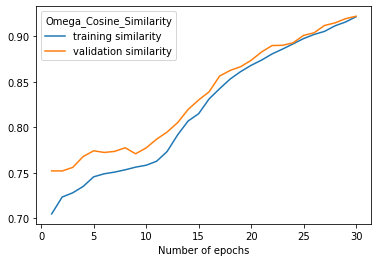

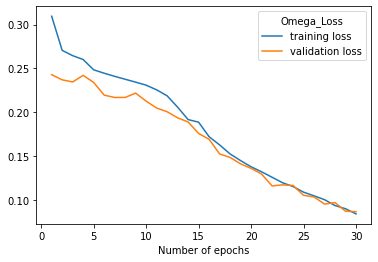

In [ ]:
# Insert your code here to obtain the lists: epochs, training similarity, validation similarity, training loss, validation loss from CSV log file (1 point)
epochs=[]
for i in range(len(hist.history['loss'])):
  epochs.append(i+1)
training_similarity=hist.history['cosine_similarity']
validation_similarity=hist.history['val_cosine_similarity']
training_loss=hist.history['loss']
validation_loss=hist.history['val_loss']

# Insert your code here to plot Epochs Vs. training and validation accuracy (2 points)
plot1=plt.figure(1)
plt.plot(epochs, training_similarity, label="training similarity")
plt.plot(epochs, validation_similarity, label="validation similarity")
plt.xlabel("Number of epochs")
plt.legend(title="Omega_Cosine_Similarity")

# Insert your code here to plot Epochs Vs. training and validation loss (2 points)
plot2=plt.figure(2)
plt.plot(epochs, training_loss, label="training loss")
plt.plot(epochs, validation_loss, label="validation loss")
plt.xlabel("Number of epochs")
plt.legend(title="Omega_Loss")


Now build and summarize the Alpha model as per the best learning rate value determined earlier. 

---

**1 Point**

---




In [ ]:
# Insert code for building model using the best LR for Alpha model determined
model=Alpha_model(learning_rate=1e-4)


Now instantiate the four callbacks for Alpha model.

---

**2 Points**

---

In [ ]:
# EarlyStopping after validation loss has not improved for 5 epochs 
model_earlystopping=tf.keras.callbacks.EarlyStopping(patience=5)

# ReduceLROnPlateau reducing LR by half when validation loss has not improved for 3 epochs. 
model_reducelronplateau=tf.keras.callbacks.ReduceLROnPlateau(factor=0.5,patience=3)

# CSVlogger for keeping logs in filename of your choice
model_csvlogger=tf.keras.callbacks.CSVLogger("Shivam_training_Alpha.log")

file_path='/content/gdrive/MyDrive/WR-Dataset_partb/alpha_model'
# ModelCheckpoint that saves the best weights of model after every 10 epochs
model_modelcheckpoint=tf.keras.callbacks.ModelCheckpoint(filepath=file_path, save_freq=10)

callbacks_list=[model_earlystopping, model_reducelronplateau, model_csvlogger, model_modelcheckpoint]

Now train the model with training data using these callbacks.

---

**7 Points**

---

In [ ]:
# Insert code to train with callbacks (2 points)
hist=model.fit(x_train, y_train_alpha_list, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(x_val, y_val_alpha_list), callbacks=callbacks_list)


Epoch 1/30
257/257 [==============================] - 205s 797ms/step - loss: 0.2803 - cosine_similarity: 0.2641 - val_loss: 0.1562 - val_cosine_similarity: 0.3179
Epoch 2/30
257/257 [==============================] - 230s 899ms/step - loss: 0.1656 - cosine_similarity: 0.3179 - val_loss: 0.1548 - val_cosine_similarity: 0.3214
Epoch 3/30
257/257 [==============================] - 238s 930ms/step - loss: 0.1642 - cosine_similarity: 0.3205 - val_loss: 0.1541 - val_cosine_similarity: 0.3192
Epoch 4/30
257/257 [==============================] - 197s 771ms/step - loss: 0.1618 - cosine_similarity: 0.3293 - val_loss: 0.1547 - val_cosine_similarity: 0.3255
Epoch 5/30
257/257 [==============================] - 248s 967ms/step - loss: 0.1620 - cosine_similarity: 0.3288 - val_loss: 0.1545 - val_cosine_similarity: 0.3273
Epoch 6/30
257/257 [==============================] - 239s 935ms/step - loss: 0.1596 - cosine_similarity: 0.3321 - val_loss: 0.1536 - val_cosine_similarity: 0.3215
Epoch 7/30
257/2

In [ ]:
model.save("/content/gdrive/MyDrive/WR-Dataset_partb/my_Alpha_model")

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/WR-Dataset_partb/my_Alpha_model/assets


In [ ]:
model.save("/content/gdrive/MyDrive/WR-Dataset_partb/my_Alpha_model_2")

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/WR-Dataset_partb/my_Alpha_model_2/assets


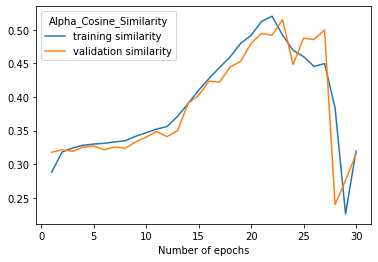

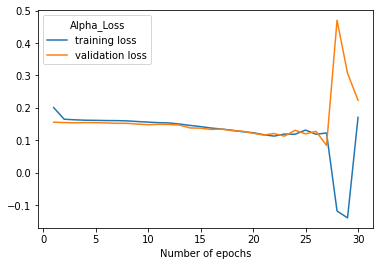

In [ ]:
# Insert your code here to obtain the lists: epochs, training similarity, validation similarity, training loss, validation loss from CSV log file (1 point)
epochs=[]
for i in range(len(hist.history['loss'])):
  epochs.append(i+1)
training_similarity=hist.history['cosine_similarity']
validation_similarity=hist.history['val_cosine_similarity']
training_loss=hist.history['loss']
validation_loss=hist.history['val_loss']

# Insert your code here to plot Epochs Vs. training and validation accuracy (2 points)
plot1=plt.figure(1)
plt.plot(epochs, training_similarity, label="training similarity")
plt.plot(epochs, validation_similarity, label="validation similarity")
plt.xlabel("Number of epochs")
plt.legend(title="Alpha_Cosine_Similarity")

# Insert your code here to plot Epochs Vs. training and validation loss (2 points)
plot2=plt.figure(2)
plt.plot(epochs, training_loss, label="training loss")
plt.plot(epochs, validation_loss, label="validation loss")
plt.xlabel("Number of epochs")
plt.legend(title="Alpha_Loss")


## Steps for Word recognition:

First, prepare a list having all the words from test set mapped to their corresponding vectors (lexicon for both Omega and Alpha representations).

---

**1 point**

---


In [ ]:
word_label=list(pd.DataFrame(test_dataframe,columns=['Label'])['Label'])
y_test_alpha=[]
y_test_seen_alpha=[]
y_test_unseen_alpha=[]
for i in word_label:
  y_test_alpha.append(get_Alpha_vector(i))
  if i not in seen_class:
    y_test_unseen_alpha.append(get_Alpha_vector(i))
  else:
    y_test_seen_alpha.append(get_Alpha_vector(i))



y_test_Omega=[]
y_test_seen_Omega=[]
y_test_unseen_Omega=[]
for i in word_label:
  y_test_Omega.append(get_Omega_vector(i))
  if i not in seen_class:
    y_test_unseen_Omega.append(get_Omega_vector(i))
  else:
    y_test_seen_Omega.append(get_Omega_vector(i))


For every image in the test set:
1. Predict the output vector representation from the trained model(s) when the image is given as input.
2. Find the word class(from lexicon) for which the similarity of its vector representation will be highest with the output vector.
3. If predicted word = true word, then it is a correct prediction, otherwise incorrect prediction.

---

Let us now perform recognition using trained Alph amodel on the test set. 

First, load the test images and their vector representations.

---

**1 point**

---

In [ ]:
# Insert code to load test images and its vector labels (1 points)
x_test=list(pd.DataFrame(test_dataframe,columns=['Image'])['Image'])
x_test=np.divide(x_test, 255)
x_test=np.array(x_test).reshape(len(x_test), 50, 250, 3)

x_test_seen=[]
x_test_unseen=[]
for i in range(len(test_dataframe['Label'])):
  if test_dataframe['Label'][i] not in seen_class:
    x_test_unseen.append(test_dataframe['Image'][i])
  else:
    x_test_seen.append(test_dataframe['Image'][i])

x_test_seen=np.divide(x_test_seen, 255)
x_test_seen=np.array(x_test_seen).reshape(len(x_test_seen), 50, 250, 3)
x_test_unseen=np.divide(x_test_unseen, 255)
x_test_unseen=np.array(x_test_unseen).reshape(len(x_test_unseen), 50, 250, 3)



y_test_alpha_list=np.empty((0,364), int)
for i in y_test_alpha:
  y_test_alpha_list=np.append(y_test_alpha_list,np.array([i]),axis=0)



Now load the saved trained Alpha model from the file and predict the labels

---

**1+3 points**

---

In [ ]:
# Insert code for loading the saved model from file 
model = tf.keras.models.load_model('/content/gdrive/MyDrive/WR-Dataset_partb/my_Alpha_model')


In [ ]:
# word_label=list(pd.DataFrame(train_dataframe,columns=['Label'])['Label'])
# Insert code for predicting word labels of the test set images 
predict_alpha_vector=model.predict(x_test, batch_size=BATCH_SIZE)
# print(predict_alpha_vector)

from scipy.spatial import distance
predicted_alpha_class=[]
Alpha_prediction=[]
for i in range(len(predict_alpha_vector)):
  label=0
  max_cossim=0
  for j in range(len(predict_alpha_vector)):
    curr_cossim=(1 - distance.cosine(predict_alpha_vector[i], y_test_alpha_list[j]))
    # print(curr_cossim)
    if curr_cossim >= max_cossim:
      max_cossim=curr_cossim
      label=j
  predicted_alpha_class.append(word_label[label])
  # print(max_cossim,"max")
  if label==i:
    Alpha_prediction.append(1)
  elif max_cossim==(1 - distance.cosine(predict_alpha_vector[i], y_test_alpha_list[i])):
    Alpha_prediction.append(1)
  else:
    Alpha_prediction.append(0)
print("True classes:")
print(word_label)
print("\n")
print("Predicted classes:")
print(predicted_alpha_class)

# print("\n")
# print("Alpha_Prediction")
# print(Alpha_prediction)
# count=0





True classes:
['he', 'any', 'comments', 'and', 'after', 'home', 'management', 'as', 'f', 'copyright', 'internet', 'many', 'design', 'index', 'any', 'available', 'into', 'from', 'made', 'january', 'd', 'local', 'into', 'first', 'did', 'address', 'c', 'at', 'games', 'find', 'center', 'internet', 'how', 'any', 'forum', 'house', 'because', 'and', 'day', 'link', 'development', 'data', 'list', 'buy', 'for', 'email', 'between', 'details', 'make', 'address', 'address', 'high', 'details', 'just', 'family', 'can', 'its', 'development', 'for', 'house', 'development', 'been', 'line', 'am', 'by', 'are', 'full', 'be', 'c', 'b', 'before', 'good', 'details', 'file', 'data', 'link', 'like', 'i', 'day', 'days', 'book', 'internet', 'black', 'here', 'forum', 'car', 'about', 'house', 'hotels', 'business', 'by', 'all', 'high', 'here', 'free', 'help', 'at', 'are', 'business', 'go', 'high', 'both', 'also', 'know', 'had', 'education', 'days', 'we', 'version', 'south', 'well', 'these', 'subject', 'with', 'than'

Let us evaluate the performance of the model. The effective accuracy of model is defined as harmonic mean(HM) of accuracy with seen class images and accuracy with unseen class images.

---

**2 Points**

---

In [ ]:
# Insert code to compute accuracy of images that belong to seen classes 
y_test_seen_alpha_list=np.empty((0,364), int)
for i in y_test_seen_alpha:
  y_test_seen_alpha_list=np.append(y_test_seen_alpha_list,np.array([i]),axis=0)
hist=model.evaluate(x_test_seen, y_test_seen_alpha_list, batch_size=BATCH_SIZE)
seen_acc_alpha=hist[1]*100
print("Accuracy of images that belong to seen classes : ", seen_acc_alpha, "%")



print("\n")
# Insert code to compute accuracy of images that belong to unseen classes
y_test_unseen_alpha_list=np.empty((0,364), int)
for i in y_test_unseen_alpha:
  y_test_unseen_alpha_list=np.append(y_test_unseen_alpha_list,np.array([i]),axis=0)
hist=model.evaluate(x_test_unseen, y_test_unseen_alpha_list, batch_size=BATCH_SIZE)
unseen_acc_alpha=hist[1]*100
print("Accuracy of images that belong to unseen classes : ", unseen_acc_alpha, "%")






print("\n")
# Insert code to compute effective accuracy
eff_acc_alpha=2*((seen_acc_alpha*unseen_acc_alpha)/(seen_acc_alpha+unseen_acc_alpha))
print(" Effective accuracy of Omega_model : ", eff_acc_alpha, "%")

30/30 [==============================] - 1s 26ms/step - loss: 0.2323 - cosine_similarity: 0.3277
Accuracy of images that belong to seen classes :  32.773080468177795 %


20/20 [==============================] - 0s 23ms/step - loss: 0.2642 - cosine_similarity: 0.3273
Accuracy of images that belong to unseen classes :  32.7258437871933 %


 Effective accuracy of Omega_model :  32.7494450945506 %


Let us now perform recognition using trained Alpha model on the test set.
 
First, load the test images and their Omega vector representations.

---

**1 Points**

---

In [ ]:
# Insert code to load test images and its vector labels (1 points)
x_test=list(pd.DataFrame(test_dataframe,columns=['Image'])['Image'])
x_test=np.divide(x_test, 255)
x_test=np.array(x_test).reshape(len(x_test), 50, 250, 3)

x_test_seen=[]
x_test_unseen=[]
for i in range(len(test_dataframe['Label'])):
  if test_dataframe['Label'][i] not in seen_class:
    x_test_unseen.append(test_dataframe['Image'][i])
  else:
    x_test_seen.append(test_dataframe['Image'][i])

x_test_seen=np.divide(x_test_seen, 255)
x_test_seen=np.array(x_test_seen).reshape(len(x_test_seen), 50, 250, 3)
x_test_unseen=np.divide(x_test_unseen, 255)
x_test_unseen=np.array(x_test_unseen).reshape(len(x_test_unseen), 50, 250, 3)

y_test_omega_list=np.empty((0,165), int)
for i in y_test_Omega:
  y_test_omega_list=np.append(y_test_omega_list,np.array([i]),axis=0)

Now load the saved trained Omega model from the file and predict the labels

---

**1+3 Points**

---

In [ ]:
# Insert code for loading the saved model from file 
model = tf.keras.models.load_model('/content/gdrive/MyDrive/WR-Dataset_partb/my_Omega_model')


In [ ]:
# word_label=list(pd.DataFrame(train_dataframe,columns=['Label'])['Label'])
# Insert code for predicting word labels of the test set images 
predict_omega_vector=model.predict(x_test, batch_size=BATCH_SIZE)
print(predict_omega_vector.shape)

from scipy.spatial import distance
predicted_omega_class=[]
Omega_prediction=[]
for i in range(len(predict_omega_vector)):
  label=0
  max_cossim=0
  for j in range(len(predict_omega_vector)):
    curr_cossim=(1 - distance.cosine(predict_omega_vector[i], y_test_omega_list[j]))
    # print(curr_cossim)
    if curr_cossim >= max_cossim:
      max_cossim=curr_cossim
      label=j
  predicted_omega_class.append(word_label[label])
  # print(max_cossim,"max")
  if label==i:
    Omega_prediction.append(1)
  elif max_cossim==(1 - distance.cosine(predict_omega_vector[i], y_test_omega_list[i])):
    Omega_prediction.append(1)
  else:
    Omega_prediction.append(0)
  
print("True classes:")
print(word_label)
print("\n")
print("Predicted classes:")
print(predicted_omega_class)

print("\n")
print("Omega_Prediction")
print(Omega_prediction)
count=0
count=0
for i in Omega_prediction:
  if i==1:
    count+=1

print("Correctly predicted label by the omega_model out of 400 test sets :")
print(count)



(400, 165)
True classes:
['he', 'any', 'comments', 'and', 'after', 'home', 'management', 'as', 'f', 'copyright', 'internet', 'many', 'design', 'index', 'any', 'available', 'into', 'from', 'made', 'january', 'd', 'local', 'into', 'first', 'did', 'address', 'c', 'at', 'games', 'find', 'center', 'internet', 'how', 'any', 'forum', 'house', 'because', 'and', 'day', 'link', 'development', 'data', 'list', 'buy', 'for', 'email', 'between', 'details', 'make', 'address', 'address', 'high', 'details', 'just', 'family', 'can', 'its', 'development', 'for', 'house', 'development', 'been', 'line', 'am', 'by', 'are', 'full', 'be', 'c', 'b', 'before', 'good', 'details', 'file', 'data', 'link', 'like', 'i', 'day', 'days', 'book', 'internet', 'black', 'here', 'forum', 'car', 'about', 'house', 'hotels', 'business', 'by', 'all', 'high', 'here', 'free', 'help', 'at', 'are', 'business', 'go', 'high', 'both', 'also', 'know', 'had', 'education', 'days', 'we', 'version', 'south', 'well', 'these', 'subject', 'wi

Evaluate the performance of the Omega model

---

**2 Points**

---

In [ ]:
# Insert code to compute accuracy of images that belong to seen classes 
y_test_seen_omega_list=np.empty((0,165), int)
for i in y_test_seen_Omega:
  y_test_seen_omega_list=np.append(y_test_seen_omega_list,np.array([i]),axis=0)

# print(y_test_seen_omega_list.shape)
hist=model.evaluate(x_test_seen, y_test_seen_omega_list, batch_size=BATCH_SIZE)
seen_acc_omega=hist[1]*100
print("Accuracy of images that belong to seen classes : ", seen_acc_omega, "%")



print("\n")
# Insert code to compute accuracy of images that belong to unseen classes
y_test_unseen_omega_list=np.empty((0,165), int)
for i in y_test_unseen_Omega:
  y_test_unseen_omega_list=np.append(y_test_unseen_omega_list,np.array([i]),axis=0)
# print(y_test_unseen_omega_list.shape)
hist=model.evaluate(x_test_unseen, y_test_unseen_omega_list, batch_size=BATCH_SIZE)
unseen_acc_omega=hist[1]*100
print("Accuracy of images that belong to unseen classes : ", unseen_acc_omega, "%")





print("\n")
# Insert code to compute effective accuracy
eff_omega_acc=2*((seen_acc_omega*unseen_acc_omega)/(seen_acc_omega+unseen_acc_omega))
print(" Effective accuracy of Omega_model : ", eff_omega_acc, "%")



30/30 [==============================] - 1s 26ms/step - loss: 0.0858 - cosine_similarity: 0.9295
Accuracy of images that belong to seen classes :  92.95475482940674 %


20/20 [==============================] - 0s 23ms/step - loss: 0.2127 - cosine_similarity: 0.8748
Accuracy of images that belong to unseen classes :  87.48266100883484 %


 Effective accuracy of Omega_model :  90.13573230499432 %


# Results
Based on your experimental outcome and your observations, which representation is better, according to you? 

---

**2 Points**
> **Omega_model** gives me the far better efficiency (**Effective accuracy almost 90%**) then the Alpha_model (Effective accuracy  32.74%) . As i keep the count of every variable with the help of omega_vector which is a representation based on
the curve shape  that i guess will be a more efficient approch to detact the hand writting words. Moreover in the case of the cosine similarity my vector need to be diversifide to get the detectable and separate value of dot product with the another vector,  again which is more in the omega representation.

---

We have used only words from the test set to find the matching word. How could results be affected if the lexicon had both: train and test words?

---

**2 Points**
> If i will use train+test to find the matching word then my effeciency would be reduce because in this case the probability is less that my predicted vector will catch maximum cosin similariry with its true label Since i am having more data samples or more variety or more words those could be the predicted word.

---